<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
import numpy as np
import os

folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\cwtnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with CWT naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_5.npy'))

# #generate random arrays for now
# eeg_fold_1 = np.random.rand(10, 224, 224,3)
# labels_fold_1 = np.random.randint(0, 3, 10)
# patients_fold_1 = np.random.randint(1, 11, 10)

# eeg_fold_2 = np.random.rand(10, 224, 224,3)
# labels_fold_2 = np.random.randint(0, 3, 10)
# patients_fold_2 = np.random.randint(1, 11, 10)

# eeg_fold_3 = np.random.rand(10, 224, 224,3)
# labels_fold_3 = np.random.randint(0, 3, 10)
# patients_fold_3 = np.random.randint(1, 11, 10)

# eeg_fold_4 = np.random.rand(10, 224, 224,3)
# labels_fold_4 = np.random.randint(0, 3, 10)
# patients_fold_4 = np.random.randint(1, 11, 10)

# eeg_fold_5 = np.random.rand(10, 224, 224,3)
# labels_fold_5 = np.random.randint(0, 3, 10)
# patients_fold_5 = np.random.randint(1, 11, 10)

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

DATA BALANCER AND EARLY STOPPING


In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




results plots


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

model and testing with random data


In [6]:
import torch
import torch.nn as nn

class LstmAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(LstmAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=2, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.act = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden*2)

        # Apply attention: Q=K=V=lstm_out
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)  # (batch, seq, hidden*2)

        # Aggregate via mean pooling or use only last time step
        pooled = attn_out.mean(dim=1)  # (batch, hidden*2)

        out = self.dropout(pooled)
        out = self.fc(out)
        return self.act(out)


In [7]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Suppose input is (batch, 224, 672) → for spectrogram shape (224, 224, 3)
# Flatten last two dims: 224 time steps, 672 features
input_size = 224 * 3
hidden_size = 128
num_layers = 1
num_classes = 3  # Binary classification (e.g., seizure vs. no seizure)

model = LstmAttention(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
model.to(device)

# Dummy input
x = torch.randn(8, 224, 672).to(device)  # batch_size=8
output = model(x)
print(output.shape)  # Expect: (8, 1)


torch.Size([8, 3])


In [8]:
from torchinfo import summary

summary(model, input_size=(8, 224, 672))

Layer (type:depth-idx)                   Output Shape              Param #
LstmAttention                            [8, 3]                    --
├─LSTM: 1-1                              [8, 224, 256]             821,248
├─MultiheadAttention: 1-2                [8, 224, 256]             263,168
├─Dropout: 1-3                           [8, 256]                  --
├─Linear: 1-4                            [8, 3]                    771
├─Softmax: 1-5                           [8, 3]                    --
Total params: 1,085,187
Trainable params: 1,085,187
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.47
Input size (MB): 4.82
Forward/backward pass size (MB): 3.67
Params size (MB): 3.29
Estimated Total Size (MB): 11.78

training code


RUNNING PARAMETER SET 1/5
Parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.4, 'learning_rate': 6.339492809821357e-05, 'weight_decay': 5.137548693679295e-06, 'batch_size': 16, 'optimizer_name': 'Adam', 'label_smoothing': 0.3, 'factor': 1}

Fold No: 1
Epoch [1/100], Loss: 1.0976, Accuracy: 0.3554
Validation Loss: 1.0937, Validation Accuracy: 0.3838
Epoch [2/100], Loss: 1.0744, Accuracy: 0.4509
Validation Loss: 1.0981, Validation Accuracy: 0.3686
Epoch [3/100], Loss: 1.0505, Accuracy: 0.4651
Validation Loss: 1.0578, Validation Accuracy: 0.4205
Epoch [4/100], Loss: 1.0477, Accuracy: 0.4987
Validation Loss: 1.0630, Validation Accuracy: 0.3741
Epoch [5/100], Loss: 1.0390, Accuracy: 0.5172
Validation Loss: 1.1224, Validation Accuracy: 0.3947
Epoch [6/100], Loss: 1.0378, Accuracy: 0.5128
Validation Loss: 1.0768, Validation Accuracy: 0.3861
Epoch [7/100], Loss: 1.0336, Accuracy: 0.5349
Validation Loss: 1.0261, Validation Accuracy: 0.4110
Epoch [8/100], Loss: 1.0216, Accuracy: 0.5

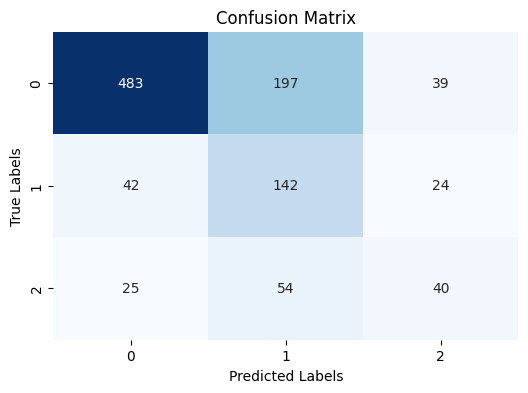


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 483/719 (67.18%)
Class 1: Correct Predictions / Total True Samples = 142/208 (68.27%)
Class 2: Correct Predictions / Total True Samples = 40/119 (33.61%)

Precision-Recall Curves:


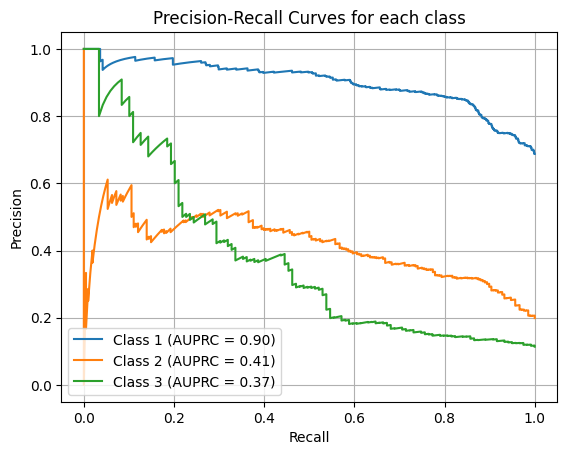


ROC Curves:


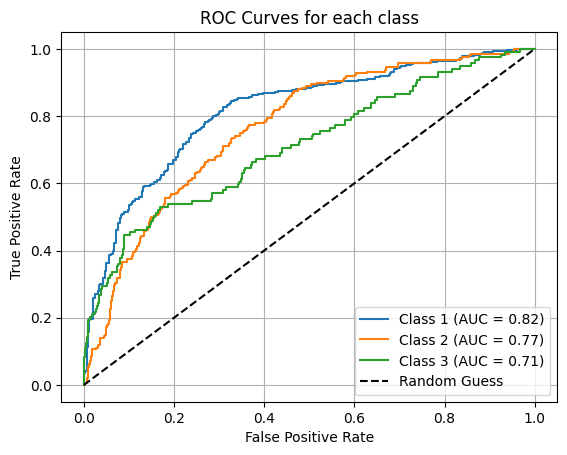


Mean F1 Score: 0.5314
Balanced Accuracy: 0.5635
Average AUPRC: 0.5607

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       719
           1       0.36      0.68      0.47       208
           2       0.39      0.34      0.36       119

    accuracy                           0.64      1046
   macro avg       0.54      0.56      0.53      1046
weighted avg       0.72      0.64      0.66      1046

Fold No: 2
Epoch [1/100], Loss: 1.0986, Accuracy: 0.3362
Validation Loss: 1.0932, Validation Accuracy: 0.4406
Epoch [2/100], Loss: 1.0883, Accuracy: 0.4268
Validation Loss: 1.0282, Validation Accuracy: 0.3962
Epoch [3/100], Loss: 1.0753, Accuracy: 0.4413
Validation Loss: 1.0224, Validation Accuracy: 0.4618
Epoch [4/100], Loss: 1.0570, Accuracy: 0.4812
Validation Loss: 1.0280, Validation Accuracy: 0.4818
Epoch [5/100], Loss: 1.0543, Accuracy: 0.4986
Validation Loss: 1.0517, Validation Accuracy: 0.4679
Epoch [6/100], Los

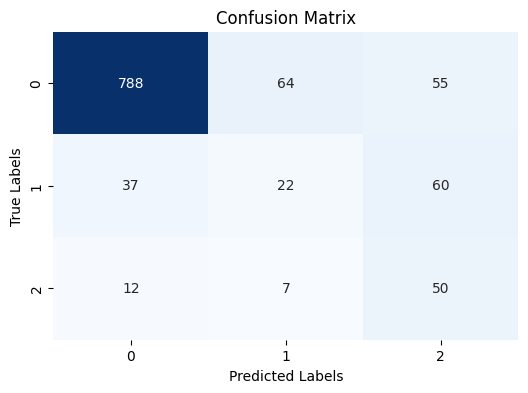


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 788/907 (86.88%)
Class 1: Correct Predictions / Total True Samples = 22/119 (18.49%)
Class 2: Correct Predictions / Total True Samples = 50/69 (72.46%)

Precision-Recall Curves:


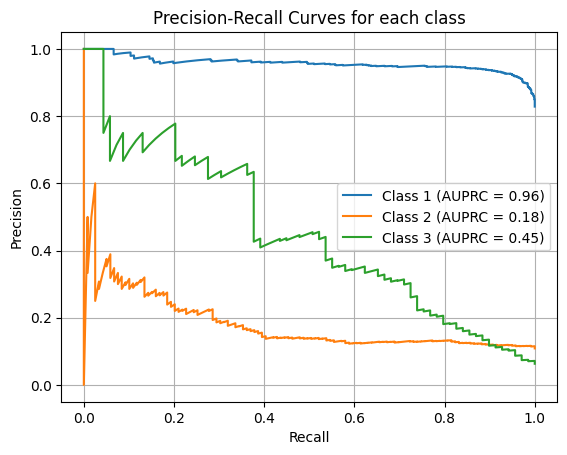


ROC Curves:


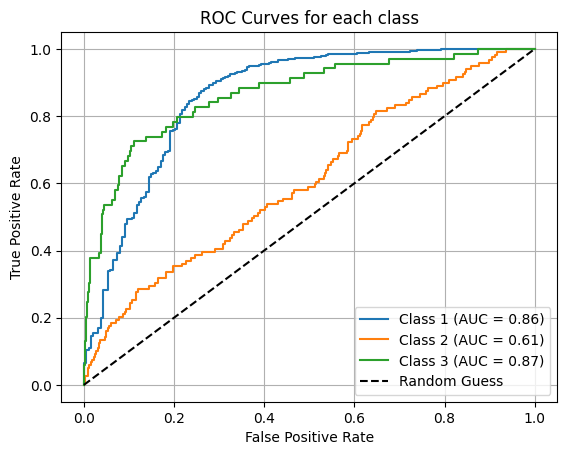


Mean F1 Score: 0.5129
Balanced Accuracy: 0.5928
Average AUPRC: 0.5271

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       907
           1       0.24      0.18      0.21       119
           2       0.30      0.72      0.43        69

    accuracy                           0.79      1095
   macro avg       0.49      0.59      0.51      1095
weighted avg       0.82      0.79      0.80      1095

Fold No: 3
Epoch [1/100], Loss: 1.0984, Accuracy: 0.3484
Validation Loss: 1.0972, Validation Accuracy: 0.3484
Epoch [2/100], Loss: 1.0849, Accuracy: 0.4418
Validation Loss: 0.9398, Validation Accuracy: 0.4640
Epoch [3/100], Loss: 1.0583, Accuracy: 0.4798
Validation Loss: 1.0766, Validation Accuracy: 0.4581
Epoch [4/100], Loss: 1.0471, Accuracy: 0.5036
Validation Loss: 1.1075, Validation Accuracy: 0.4451
Epoch [5/100], Loss: 1.0450, Accuracy: 0.5194
Validation Loss: 1.0213, Validation Accuracy: 0.4782
Epoch [6/100], Los

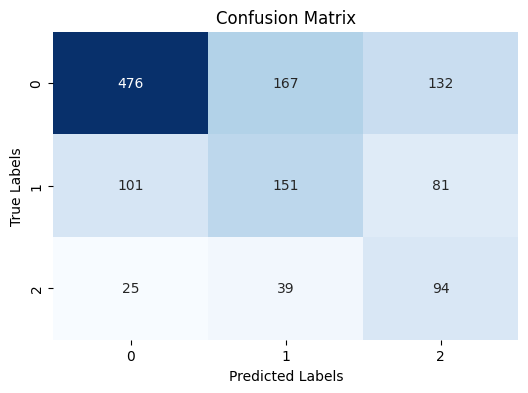


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 476/775 (61.42%)
Class 1: Correct Predictions / Total True Samples = 151/333 (45.35%)
Class 2: Correct Predictions / Total True Samples = 94/158 (59.49%)

Precision-Recall Curves:


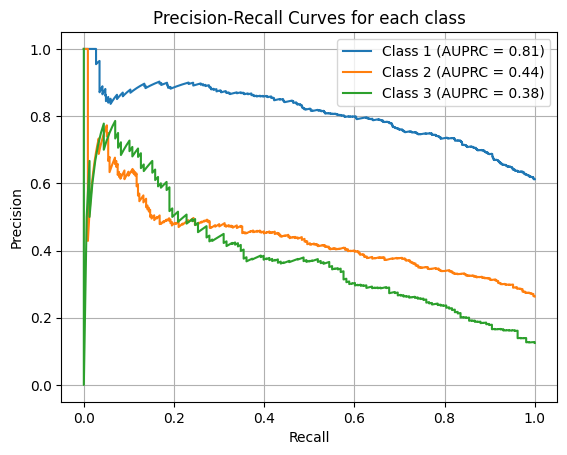


ROC Curves:


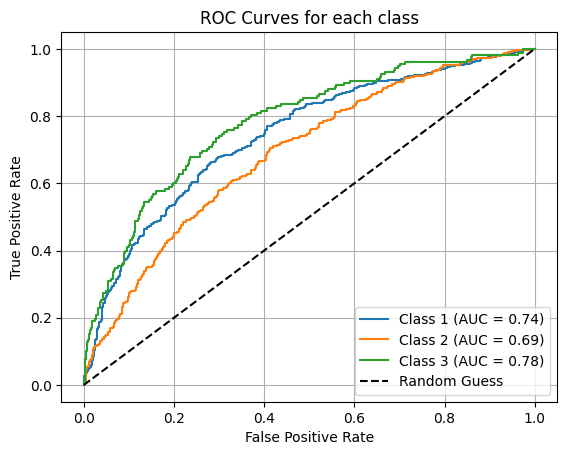


Mean F1 Score: 0.5111
Balanced Accuracy: 0.5542
Average AUPRC: 0.5420

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       775
           1       0.42      0.45      0.44       333
           2       0.31      0.59      0.40       158

    accuracy                           0.57      1266
   macro avg       0.51      0.55      0.51      1266
weighted avg       0.63      0.57      0.59      1266

Fold No: 4
Epoch [1/100], Loss: 1.0986, Accuracy: 0.3461
Validation Loss: 1.0984, Validation Accuracy: 0.3695
Epoch [2/100], Loss: 1.0946, Accuracy: 0.4255
Validation Loss: 1.1185, Validation Accuracy: 0.3717
Epoch [3/100], Loss: 1.0642, Accuracy: 0.4686
Validation Loss: 1.0297, Validation Accuracy: 0.4616
Epoch [4/100], Loss: 1.0551, Accuracy: 0.4941
Validation Loss: 1.0147, Validation Accuracy: 0.4761
Epoch [5/100], Loss: 1.0574, Accuracy: 0.4676
Validation Loss: 1.0540, Validation Accuracy: 0.4700
Epoch [6/100], Los

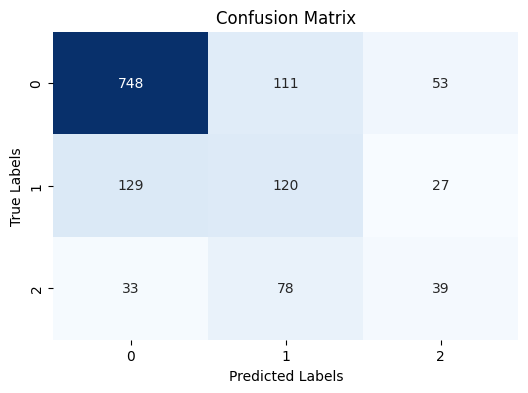


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 748/912 (82.02%)
Class 1: Correct Predictions / Total True Samples = 120/276 (43.48%)
Class 2: Correct Predictions / Total True Samples = 39/150 (26.00%)

Precision-Recall Curves:


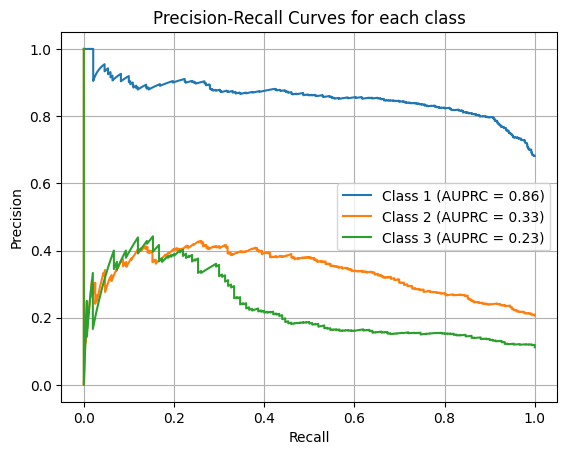


ROC Curves:


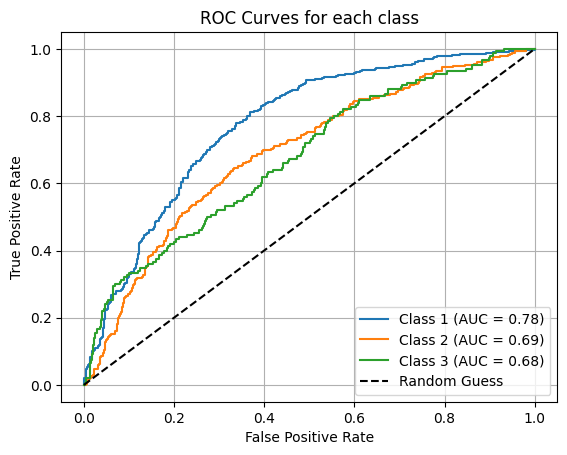


Mean F1 Score: 0.5071
Balanced Accuracy: 0.5050
Average AUPRC: 0.4729

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       912
           1       0.39      0.43      0.41       276
           2       0.33      0.26      0.29       150

    accuracy                           0.68      1338
   macro avg       0.51      0.50      0.51      1338
weighted avg       0.68      0.68      0.68      1338

Fold No: 5
Epoch [1/100], Loss: 1.0985, Accuracy: 0.3459
Validation Loss: 1.0986, Validation Accuracy: 0.5044
Epoch [2/100], Loss: 1.0954, Accuracy: 0.3921
Validation Loss: 1.0459, Validation Accuracy: 0.4190
Epoch [3/100], Loss: 1.0730, Accuracy: 0.4653
Validation Loss: 1.0245, Validation Accuracy: 0.5089
Epoch [4/100], Loss: 1.0573, Accuracy: 0.4846
Validation Loss: 0.9995, Validation Accuracy: 0.5767
Epoch [5/100], Loss: 1.0505, Accuracy: 0.5077
Validation Loss: 1.0177, Validation Accuracy: 0.5554
Epoch [6/100], Los

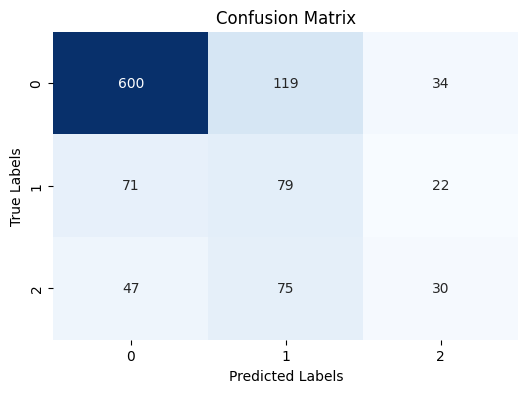


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 600/753 (79.68%)
Class 1: Correct Predictions / Total True Samples = 79/172 (45.93%)
Class 2: Correct Predictions / Total True Samples = 30/152 (19.74%)

Precision-Recall Curves:


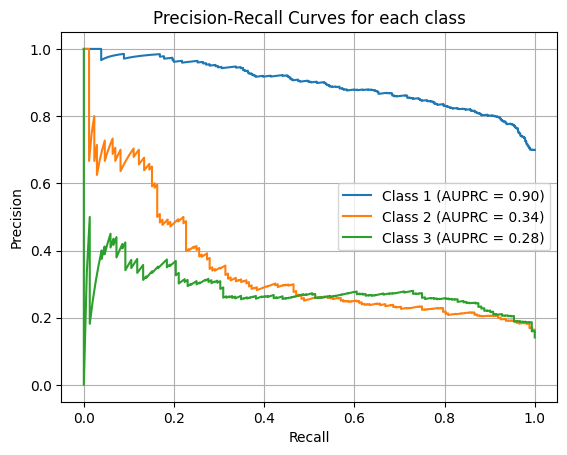


ROC Curves:


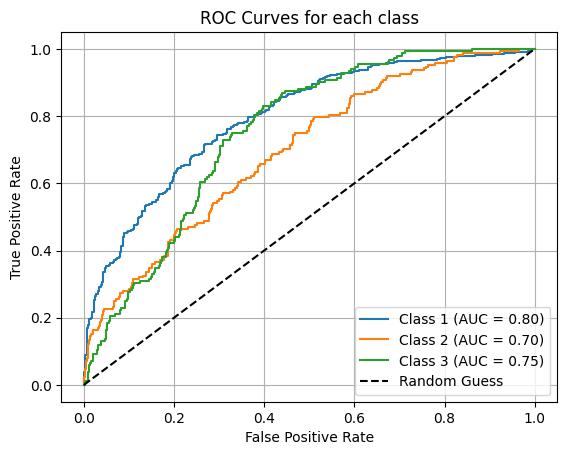


Mean F1 Score: 0.4743
Balanced Accuracy: 0.4845
Average AUPRC: 0.5067

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       753
           1       0.29      0.46      0.36       172
           2       0.35      0.20      0.25       152

    accuracy                           0.66      1077
   macro avg       0.49      0.48      0.47      1077
weighted avg       0.68      0.66      0.66      1077


RESULTS FOR PARAMETER SET 1
Accuracy for each fold: ['0.5635', '0.5928', '0.5542', '0.5050', '0.4845']
Average Accuracy: 0.5400
AUPRC for each fold: ['0.5607', '0.5271', '0.5420', '0.4729', '0.5067']
Average AUPRC: 0.5219
Best fold class-wise balanced accuracy: ['0.8243', '0.3094', '0.2717']


RUNNING PARAMETER SET 2/5
Parameters: {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 1.6047306777985417e-06, 'weight_decay': 1.6488292763592139e-06, 'batch_size': 10, 'optimizer_name': 'Ad

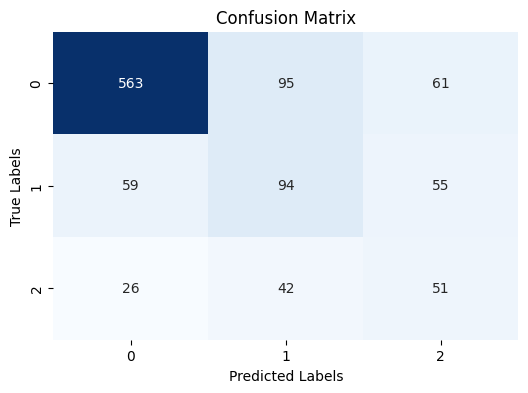


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 563/719 (78.30%)
Class 1: Correct Predictions / Total True Samples = 94/208 (45.19%)
Class 2: Correct Predictions / Total True Samples = 51/119 (42.86%)

Precision-Recall Curves:


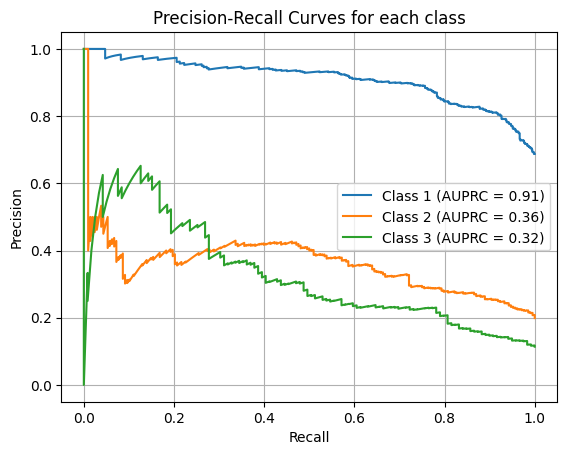


ROC Curves:


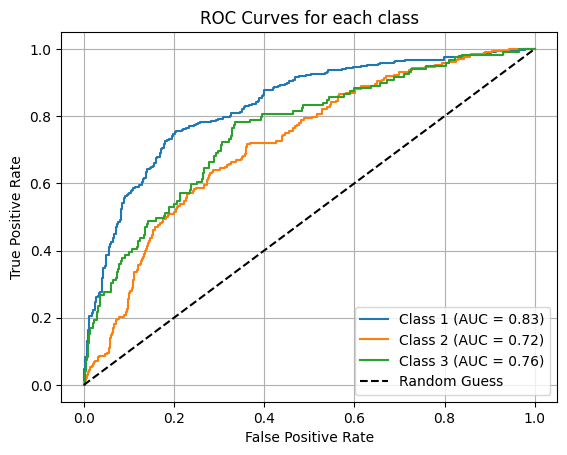


Mean F1 Score: 0.5362
Balanced Accuracy: 0.5545
Average AUPRC: 0.5301

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       719
           1       0.41      0.45      0.43       208
           2       0.31      0.43      0.36       119

    accuracy                           0.68      1046
   macro avg       0.53      0.55      0.54      1046
weighted avg       0.71      0.68      0.69      1046

Fold No: 2
Epoch [1/100], Loss: 1.0980, Accuracy: 0.3594
Validation Loss: 1.0977, Validation Accuracy: 0.4387
Epoch [2/100], Loss: 1.0949, Accuracy: 0.4029
Validation Loss: 1.0958, Validation Accuracy: 0.4444
Epoch [3/100], Loss: 1.0934, Accuracy: 0.4326
Validation Loss: 1.0928, Validation Accuracy: 0.4623
Epoch [4/100], Loss: 1.0902, Accuracy: 0.4819
Validation Loss: 1.0901, Validation Accuracy: 0.4713
Epoch [5/100], Loss: 1.0875, Accuracy: 0.4993
Validation Loss: 1.0871, Validation Accuracy: 0.4560
Epoch [6/100], Los

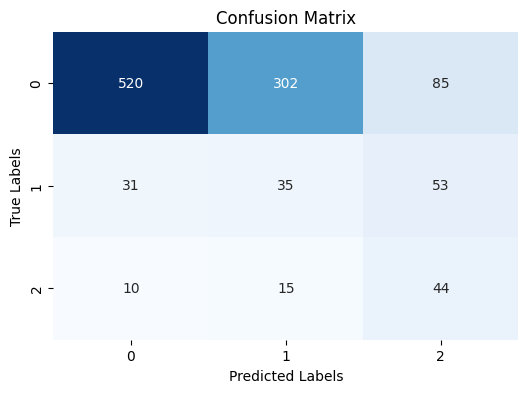


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 520/907 (57.33%)
Class 1: Correct Predictions / Total True Samples = 35/119 (29.41%)
Class 2: Correct Predictions / Total True Samples = 44/69 (63.77%)

Precision-Recall Curves:


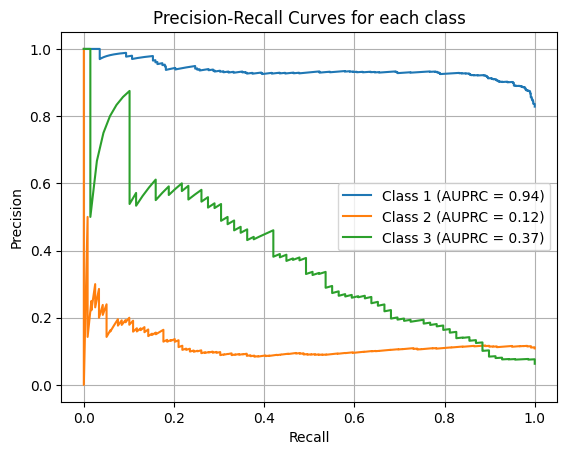


ROC Curves:


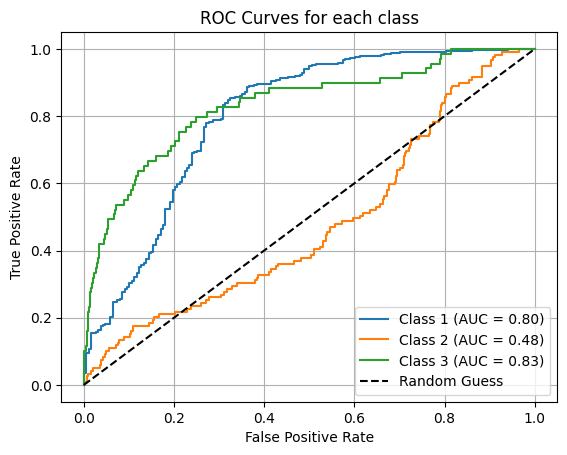


Mean F1 Score: 0.4026
Balanced Accuracy: 0.5017
Average AUPRC: 0.4753

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71       907
           1       0.10      0.29      0.15       119
           2       0.24      0.64      0.35        69

    accuracy                           0.55      1095
   macro avg       0.42      0.50      0.40      1095
weighted avg       0.79      0.55      0.63      1095

Fold No: 3
Epoch [1/100], Loss: 1.0986, Accuracy: 0.3484
Validation Loss: 1.1009, Validation Accuracy: 0.3634
Epoch [2/100], Loss: 1.0967, Accuracy: 0.3872
Validation Loss: 1.0919, Validation Accuracy: 0.3874
Epoch [3/100], Loss: 1.0937, Accuracy: 0.4347
Validation Loss: 1.0912, Validation Accuracy: 0.4572
Epoch [4/100], Loss: 1.0917, Accuracy: 0.4568
Validation Loss: 1.0894, Validation Accuracy: 0.4633
Epoch [5/100], Loss: 1.0896, Accuracy: 0.4972
Validation Loss: 1.0882, Validation Accuracy: 0.4501
Epoch [6/100], Los

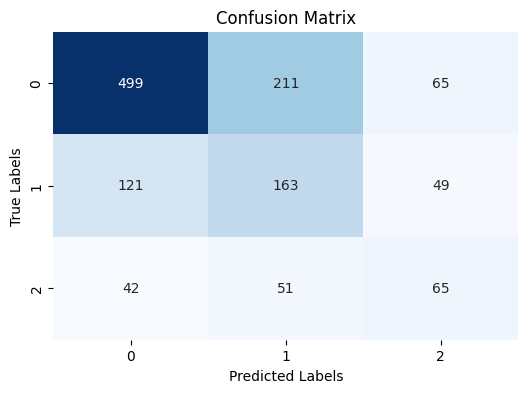


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 499/775 (64.39%)
Class 1: Correct Predictions / Total True Samples = 163/333 (48.95%)
Class 2: Correct Predictions / Total True Samples = 65/158 (41.14%)

Precision-Recall Curves:


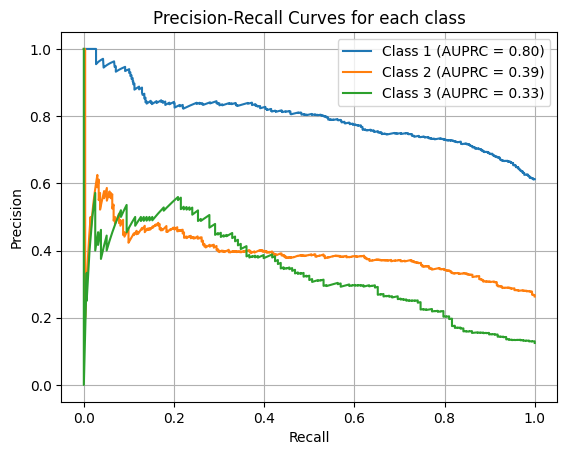


ROC Curves:


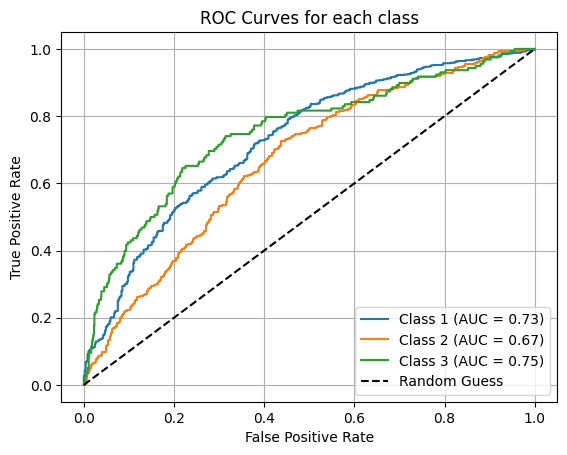


Mean F1 Score: 0.5034
Balanced Accuracy: 0.5149
Average AUPRC: 0.5073

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       775
           1       0.38      0.49      0.43       333
           2       0.36      0.41      0.39       158

    accuracy                           0.57      1266
   macro avg       0.50      0.51      0.50      1266
weighted avg       0.61      0.57      0.59      1266

Fold No: 4
Epoch [1/100], Loss: 1.0982, Accuracy: 0.3696
Validation Loss: 1.0981, Validation Accuracy: 0.4067
Epoch [2/100], Loss: 1.0968, Accuracy: 0.3912
Validation Loss: 1.0958, Validation Accuracy: 0.4581
Epoch [3/100], Loss: 1.0948, Accuracy: 0.4314
Validation Loss: 1.0937, Validation Accuracy: 0.4648
Epoch [4/100], Loss: 1.0937, Accuracy: 0.4431
Validation Loss: 1.0936, Validation Accuracy: 0.4748
Epoch [5/100], Loss: 1.0918, Accuracy: 0.4725
Validation Loss: 1.0918, Validation Accuracy: 0.4701
Epoch [6/100], Los

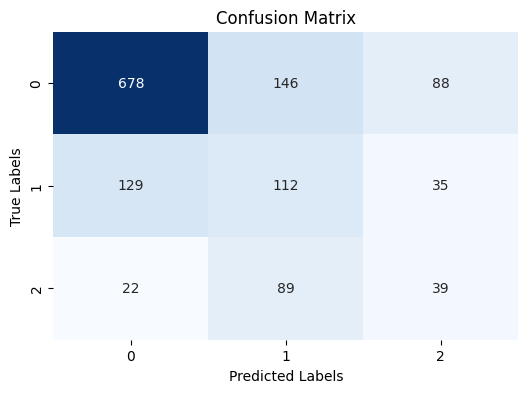


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 678/912 (74.34%)
Class 1: Correct Predictions / Total True Samples = 112/276 (40.58%)
Class 2: Correct Predictions / Total True Samples = 39/150 (26.00%)

Precision-Recall Curves:


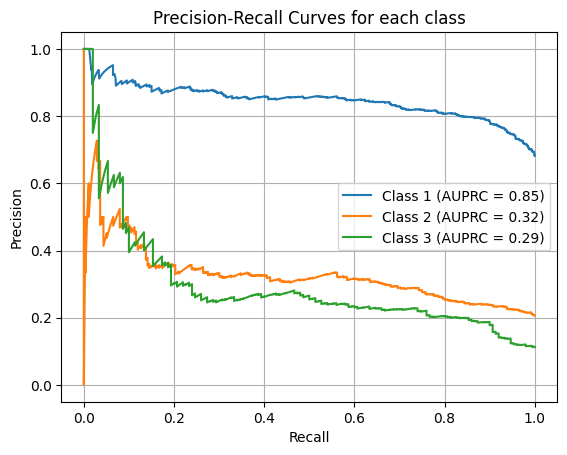


ROC Curves:


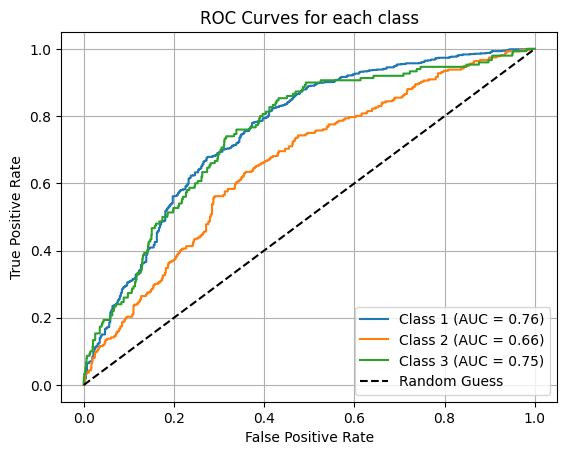


Mean F1 Score: 0.4628
Balanced Accuracy: 0.4697
Average AUPRC: 0.4871

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       912
           1       0.32      0.41      0.36       276
           2       0.24      0.26      0.25       150

    accuracy                           0.62      1338
   macro avg       0.46      0.47      0.46      1338
weighted avg       0.65      0.62      0.63      1338

Fold No: 5
Epoch [1/100], Loss: 1.0996, Accuracy: 0.3083
Validation Loss: 1.1027, Validation Accuracy: 0.3429
Epoch [2/100], Loss: 1.0971, Accuracy: 0.3690
Validation Loss: 1.0985, Validation Accuracy: 0.3922
Epoch [3/100], Loss: 1.0959, Accuracy: 0.3960
Validation Loss: 1.0952, Validation Accuracy: 0.5206
Epoch [4/100], Loss: 1.0945, Accuracy: 0.4451
Validation Loss: 1.0962, Validation Accuracy: 0.5555
Epoch [5/100], Loss: 1.0916, Accuracy: 0.4884
Validation Loss: 1.0922, Validation Accuracy: 0.5682
Epoch [6/100], Los

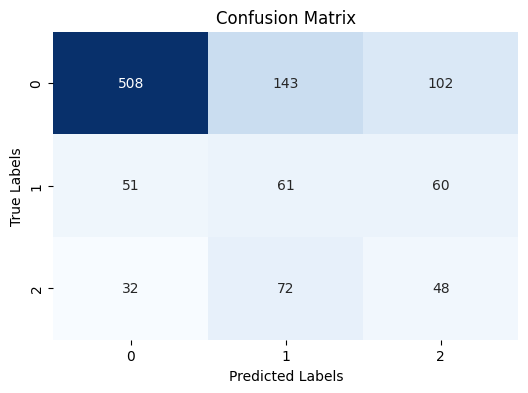


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 508/753 (67.46%)
Class 1: Correct Predictions / Total True Samples = 61/172 (35.47%)
Class 2: Correct Predictions / Total True Samples = 48/152 (31.58%)

Precision-Recall Curves:


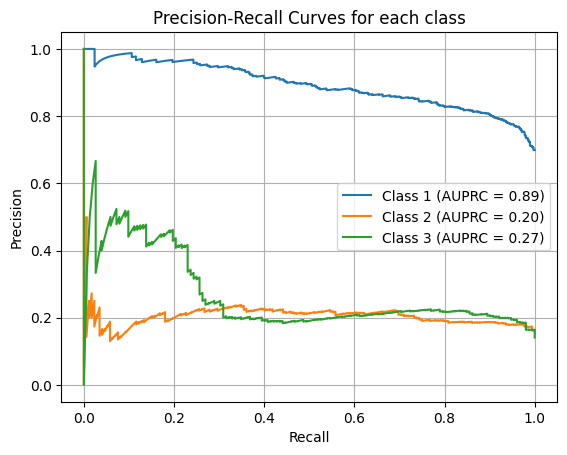


ROC Curves:


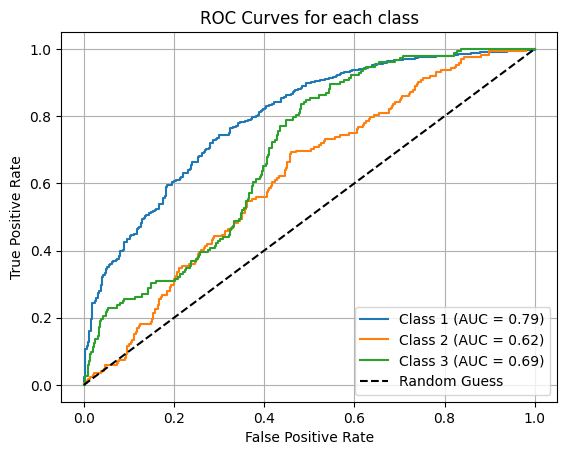


Mean F1 Score: 0.4312
Balanced Accuracy: 0.4484
Average AUPRC: 0.4536

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76       753
           1       0.22      0.35      0.27       172
           2       0.23      0.32      0.27       152

    accuracy                           0.57      1077
   macro avg       0.44      0.45      0.43      1077
weighted avg       0.67      0.57      0.61      1077


RESULTS FOR PARAMETER SET 2
Accuracy for each fold: ['0.5545', '0.5017', '0.5149', '0.4697', '0.4484']
Average Accuracy: 0.4978
AUPRC for each fold: ['0.5301', '0.4753', '0.5073', '0.4871', '0.4536']
Average AUPRC: 0.4907
Best fold class-wise balanced accuracy: ['0.7002', '0.2739', '0.2390']


RUNNING PARAMETER SET 3/5
Parameters: {'hidden_size': 1024, 'num_layers': 2, 'dropout': 0.5, 'learning_rate': 0.00032747731661669424, 'weight_decay': 2.1882109116149925e-06, 'batch_size': 10, 'optimizer_name': 'Adam', 'label_smo

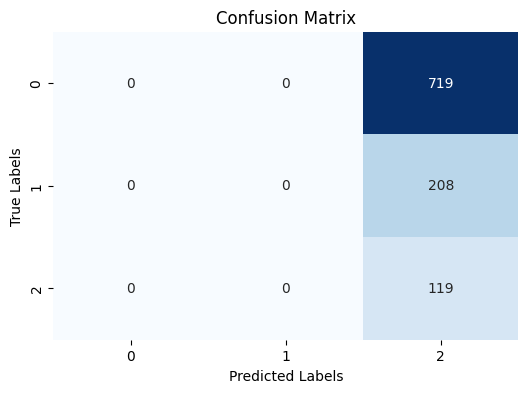


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/719 (0.00%)
Class 1: Correct Predictions / Total True Samples = 0/208 (0.00%)
Class 2: Correct Predictions / Total True Samples = 119/119 (100.00%)

Precision-Recall Curves:


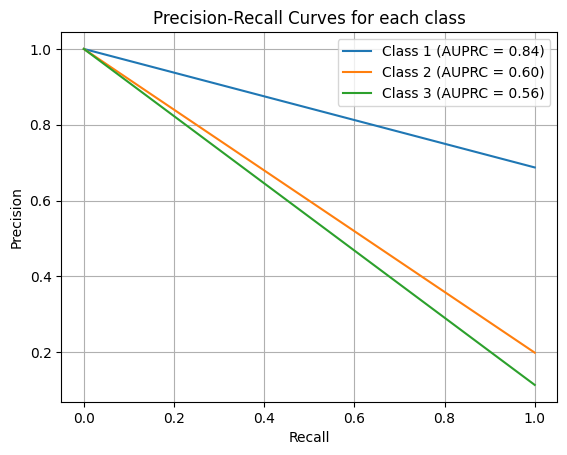


ROC Curves:


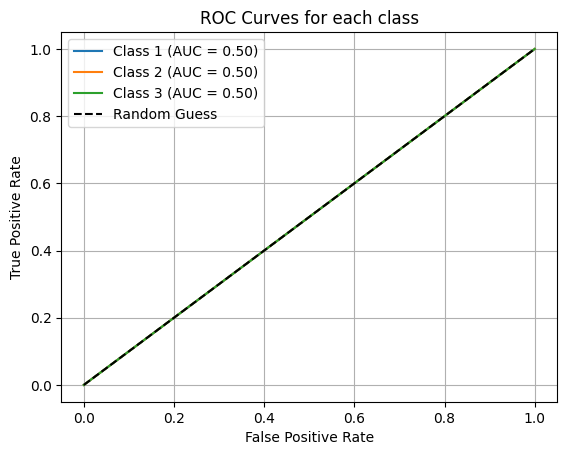


Mean F1 Score: 0.0681
Balanced Accuracy: 0.3333
Average AUPRC: 0.6667

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       719
           1       0.00      0.00      0.00       208
           2       0.11      1.00      0.20       119

    accuracy                           0.11      1046
   macro avg       0.04      0.33      0.07      1046
weighted avg       0.01      0.11      0.02      1046

Fold No: 2


c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.0953, Accuracy: 0.3768
Validation Loss: 1.0746, Validation Accuracy: 0.4455
Epoch [2/100], Loss: 1.0800, Accuracy: 0.4543
Validation Loss: 0.9684, Validation Accuracy: 0.4037
Epoch [3/100], Loss: 1.0632, Accuracy: 0.4797
Validation Loss: 1.0244, Validation Accuracy: 0.4988
Epoch [4/100], Loss: 1.0696, Accuracy: 0.4623
Validation Loss: 1.0235, Validation Accuracy: 0.4937
Epoch [5/100], Loss: 1.0544, Accuracy: 0.4855
Validation Loss: 1.0331, Validation Accuracy: 0.5140
Epoch [6/100], Loss: 1.0473, Accuracy: 0.5058
Validation Loss: 1.0167, Validation Accuracy: 0.5063
Epoch [7/100], Loss: 1.0576, Accuracy: 0.4935
Validation Loss: 1.0942, Validation Accuracy: 0.4681
Epoch [8/100], Loss: 1.0575, Accuracy: 0.4797
Validation Loss: 0.9983, Validation Accuracy: 0.4812
Epoch [9/100], Loss: 1.0683, Accuracy: 0.4399
Validation Loss: 1.0211, Validation Accuracy: 0.4612
Epoch [10/100], Loss: 1.0467, Accuracy: 0.4971
Validation Loss: 0.9512, Validation Accuracy: 0.4594
Epoch [11

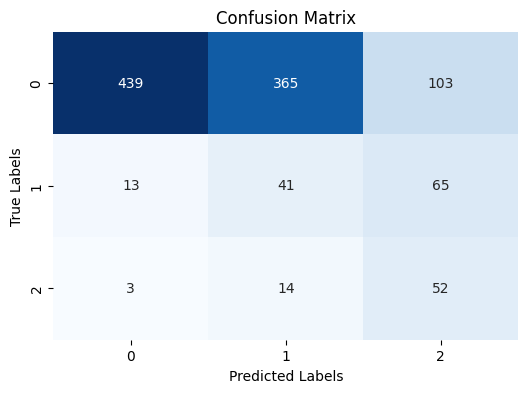


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 439/907 (48.40%)
Class 1: Correct Predictions / Total True Samples = 41/119 (34.45%)
Class 2: Correct Predictions / Total True Samples = 52/69 (75.36%)

Precision-Recall Curves:


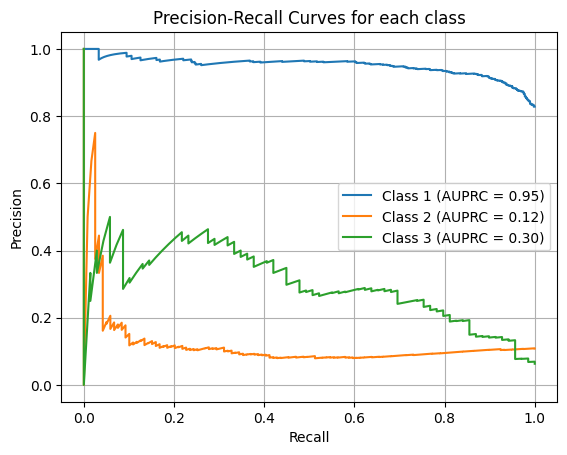


ROC Curves:


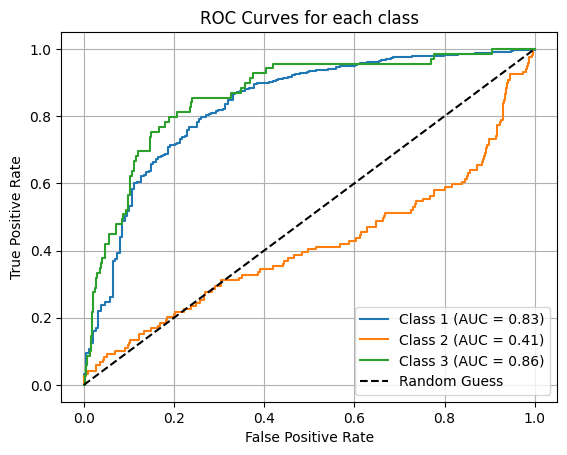


Mean F1 Score: 0.3855
Balanced Accuracy: 0.5274
Average AUPRC: 0.4542

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.48      0.64       907
           1       0.10      0.34      0.15       119
           2       0.24      0.75      0.36        69

    accuracy                           0.49      1095
   macro avg       0.43      0.53      0.39      1095
weighted avg       0.82      0.49      0.57      1095

Fold No: 3
Epoch [1/100], Loss: 1.1036, Accuracy: 0.3579
Validation Loss: 1.1710, Validation Accuracy: 0.3678
Epoch [2/100], Loss: 1.0753, Accuracy: 0.4378
Validation Loss: 1.0495, Validation Accuracy: 0.5225
Epoch [3/100], Loss: 1.0695, Accuracy: 0.4608
Validation Loss: 1.0703, Validation Accuracy: 0.5036
Epoch [4/100], Loss: 1.0568, Accuracy: 0.4743
Validation Loss: 1.0542, Validation Accuracy: 0.4839
Epoch [5/100], Loss: 1.0576, Accuracy: 0.4901
Validation Loss: 1.0768, Validation Accuracy: 0.4877
Epoch [6/100], Los

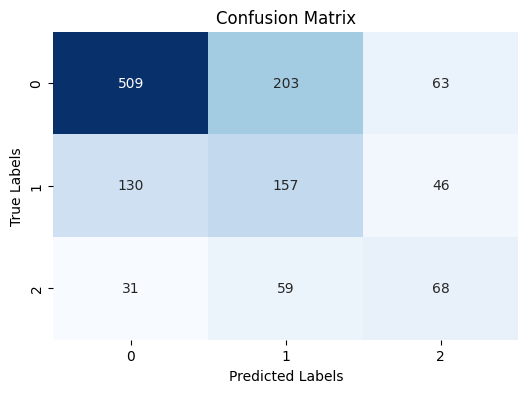


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 509/775 (65.68%)
Class 1: Correct Predictions / Total True Samples = 157/333 (47.15%)
Class 2: Correct Predictions / Total True Samples = 68/158 (43.04%)

Precision-Recall Curves:


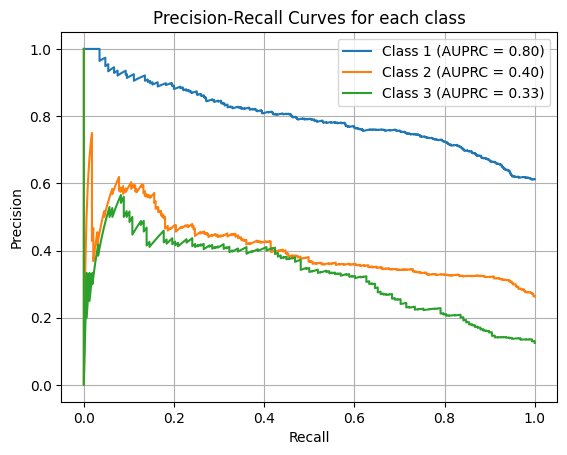


ROC Curves:


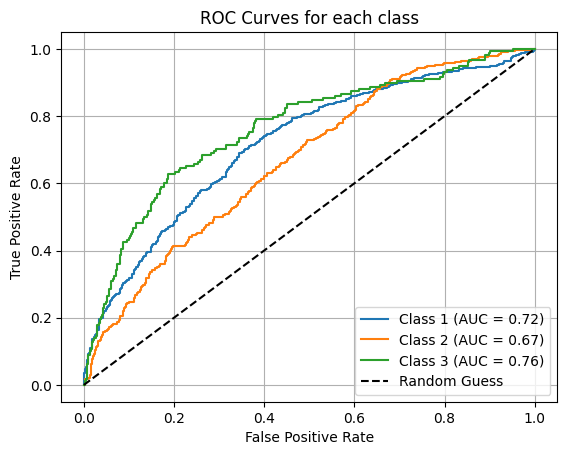


Mean F1 Score: 0.5093
Balanced Accuracy: 0.5195
Average AUPRC: 0.5086

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.70       775
           1       0.37      0.47      0.42       333
           2       0.38      0.43      0.41       158

    accuracy                           0.58      1266
   macro avg       0.51      0.52      0.51      1266
weighted avg       0.61      0.58      0.59      1266

Fold No: 4
Epoch [1/100], Loss: 1.1096, Accuracy: 0.3382
Validation Loss: 1.1113, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.0995, Accuracy: 0.3314
Validation Loss: 1.0985, Validation Accuracy: 0.3388
Epoch [3/100], Loss: 1.0943, Accuracy: 0.3716
Validation Loss: 1.1388, Validation Accuracy: 0.3389
Epoch [4/100], Loss: 1.0971, Accuracy: 0.3775
Validation Loss: 1.2030, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.0984, Accuracy: 0.3569
Validation Loss: 1.0158, Validation Accuracy: 0.3333
Epoch [6/100], Los

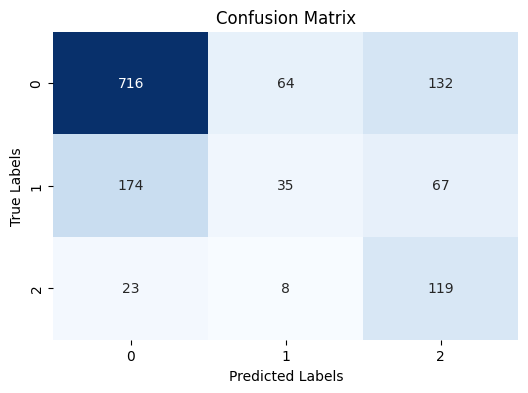


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 716/912 (78.51%)
Class 1: Correct Predictions / Total True Samples = 35/276 (12.68%)
Class 2: Correct Predictions / Total True Samples = 119/150 (79.33%)

Precision-Recall Curves:


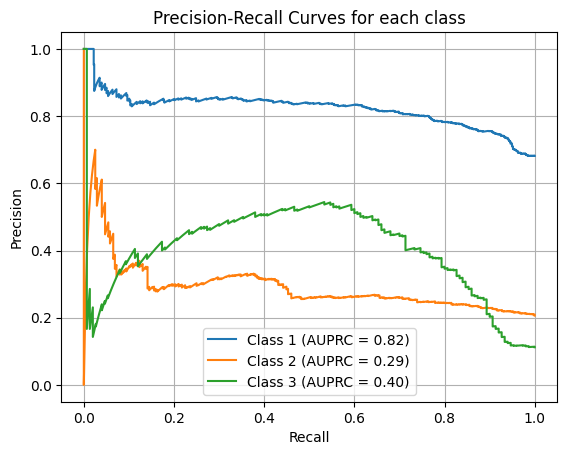


ROC Curves:


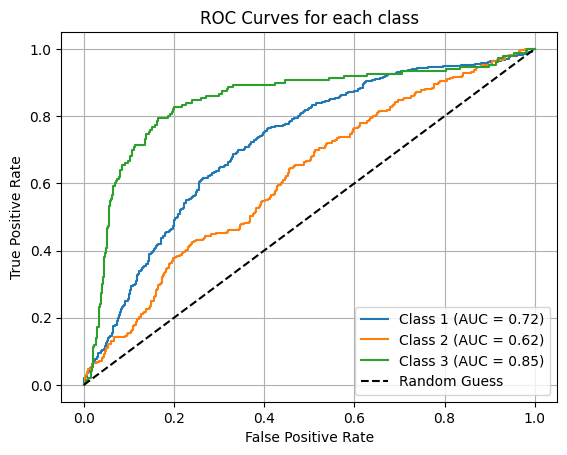


Mean F1 Score: 0.4920
Balanced Accuracy: 0.5684
Average AUPRC: 0.5049

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       912
           1       0.33      0.13      0.18       276
           2       0.37      0.79      0.51       150

    accuracy                           0.65      1338
   macro avg       0.50      0.57      0.49      1338
weighted avg       0.64      0.65      0.63      1338

Fold No: 5
Epoch [1/100], Loss: 1.2158, Accuracy: 0.3324
Validation Loss: 1.3070, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.2186, Accuracy: 0.3333
Validation Loss: 1.3070, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.2177, Accuracy: 0.3333
Validation Loss: 1.3070, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.2182, Accuracy: 0.3324
Validation Loss: 0.9742, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.2181, Accuracy: 0.3333
Validation Loss: 0.9742, Validation Accuracy: 0.3333
Epoch [6/100], Los

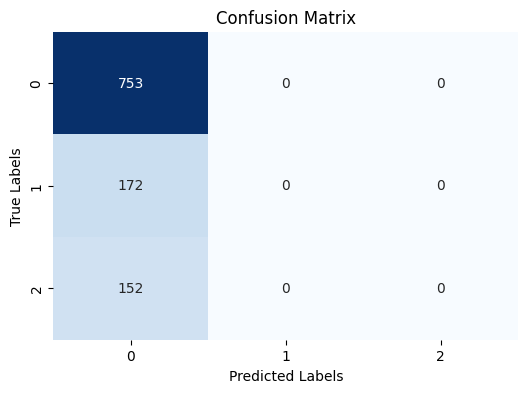


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 753/753 (100.00%)
Class 1: Correct Predictions / Total True Samples = 0/172 (0.00%)
Class 2: Correct Predictions / Total True Samples = 0/152 (0.00%)

Precision-Recall Curves:


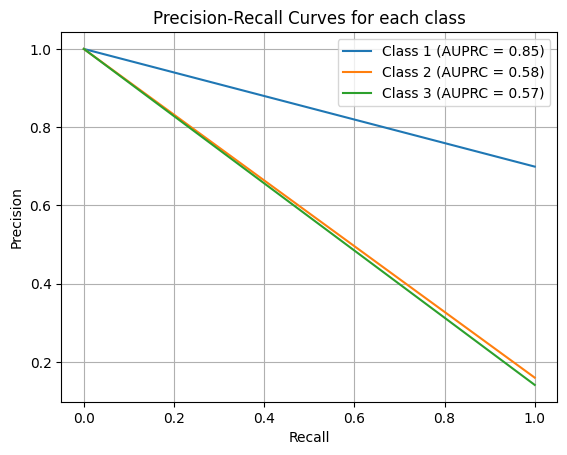


ROC Curves:


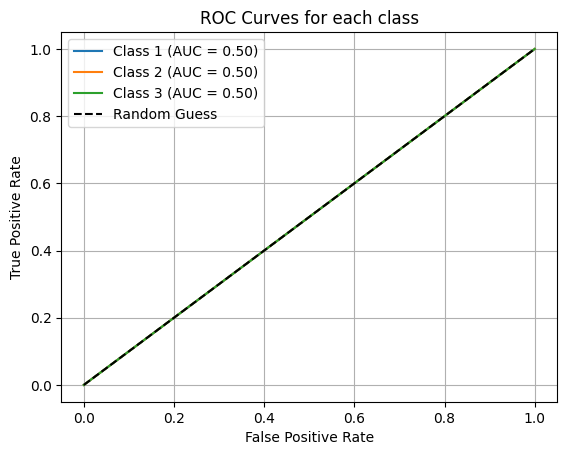


Mean F1 Score: 0.2743
Balanced Accuracy: 0.3333
Average AUPRC: 0.6667

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       753
           1       0.00      0.00      0.00       172
           2       0.00      0.00      0.00       152

    accuracy                           0.70      1077
   macro avg       0.23      0.33      0.27      1077
weighted avg       0.49      0.70      0.58      1077


RESULTS FOR PARAMETER SET 3
Accuracy for each fold: ['0.3333', '0.5274', '0.5195', '0.5684', '0.3333']
Average Accuracy: 0.4564
AUPRC for each fold: ['0.6667', '0.4542', '0.5086', '0.5049', '0.6667']
Average AUPRC: 0.5602
Best fold class-wise balanced accuracy: ['0.6992', '0.2639', '0.3410']


RUNNING PARAMETER SET 4/5
Parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.5, 'learning_rate': 6.227130451805968e-05, 'weight_decay': 2.7093785717647777e-06, 'batch_size': 16, 'optimizer_name': 'Adam', 'label_smoot

c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.0956, Accuracy: 0.3634
Validation Loss: 1.1252, Validation Accuracy: 0.3378
Epoch [2/100], Loss: 1.0552, Accuracy: 0.4775
Validation Loss: 1.0987, Validation Accuracy: 0.3624
Epoch [3/100], Loss: 1.0410, Accuracy: 0.5084
Validation Loss: 1.1313, Validation Accuracy: 0.4079
Epoch [4/100], Loss: 1.0334, Accuracy: 0.5252
Validation Loss: 1.1045, Validation Accuracy: 0.3840
Epoch [5/100], Loss: 1.0274, Accuracy: 0.5535
Validation Loss: 1.0317, Validation Accuracy: 0.4232
Epoch [6/100], Loss: 1.0286, Accuracy: 0.5447
Validation Loss: 1.1356, Validation Accuracy: 0.3556
Epoch [7/100], Loss: 1.0200, Accuracy: 0.5544
Validation Loss: 0.9556, Validation Accuracy: 0.4129
Epoch [8/100], Loss: 1.0342, Accuracy: 0.5314
Validation Loss: 0.9866, Validation Accuracy: 0.4529
Epoch [9/100], Loss: 1.0121, Accuracy: 0.5800
Validation Loss: 0.9763, Validation Accuracy: 0.4352
Epoch [10/100], Loss: 1.0063, Accuracy: 0.6012
Validation Loss: 1.0511, Validation Accuracy: 0.4293
Epoch [11

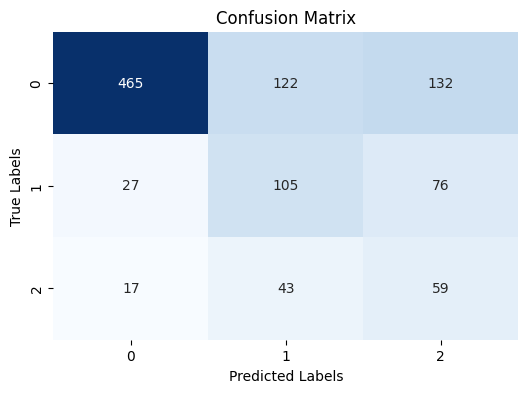


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 465/719 (64.67%)
Class 1: Correct Predictions / Total True Samples = 105/208 (50.48%)
Class 2: Correct Predictions / Total True Samples = 59/119 (49.58%)

Precision-Recall Curves:


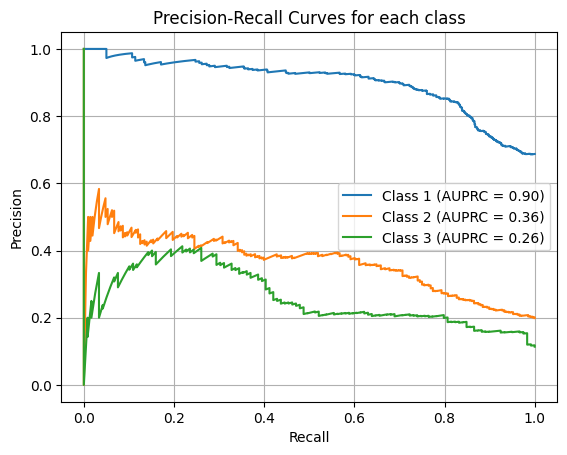


ROC Curves:


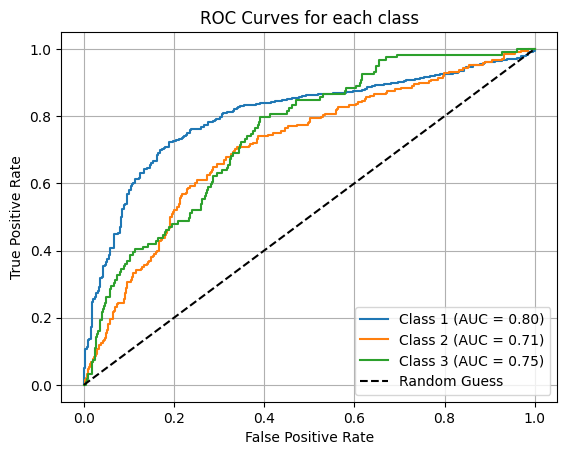


Mean F1 Score: 0.5008
Balanced Accuracy: 0.5491
Average AUPRC: 0.5071

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       719
           1       0.39      0.50      0.44       208
           2       0.22      0.50      0.31       119

    accuracy                           0.60      1046
   macro avg       0.51      0.55      0.50      1046
weighted avg       0.73      0.60      0.64      1046

Fold No: 2
Epoch [1/100], Loss: 1.0964, Accuracy: 0.3609
Validation Loss: 1.1187, Validation Accuracy: 0.3652
Epoch [2/100], Loss: 1.0699, Accuracy: 0.4572
Validation Loss: 1.0317, Validation Accuracy: 0.4955
Epoch [3/100], Loss: 1.0558, Accuracy: 0.4920
Validation Loss: 1.0649, Validation Accuracy: 0.4833
Epoch [4/100], Loss: 1.0416, Accuracy: 0.5268
Validation Loss: 1.0676, Validation Accuracy: 0.4806
Epoch [5/100], Loss: 1.0422, Accuracy: 0.5196
Validation Loss: 1.0707, Validation Accuracy: 0.4716
Epoch [6/100], Los

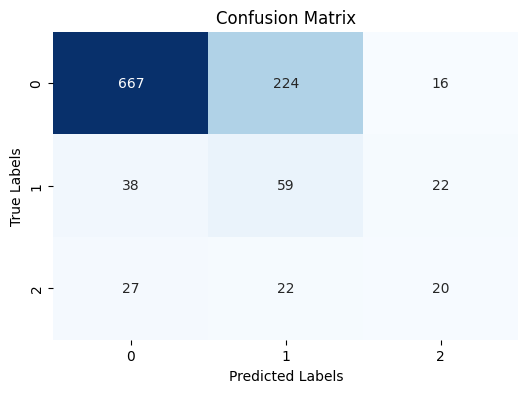


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 667/907 (73.54%)
Class 1: Correct Predictions / Total True Samples = 59/119 (49.58%)
Class 2: Correct Predictions / Total True Samples = 20/69 (28.99%)

Precision-Recall Curves:


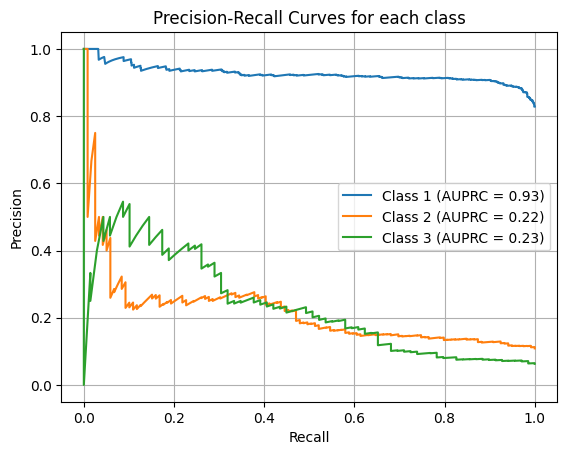


ROC Curves:


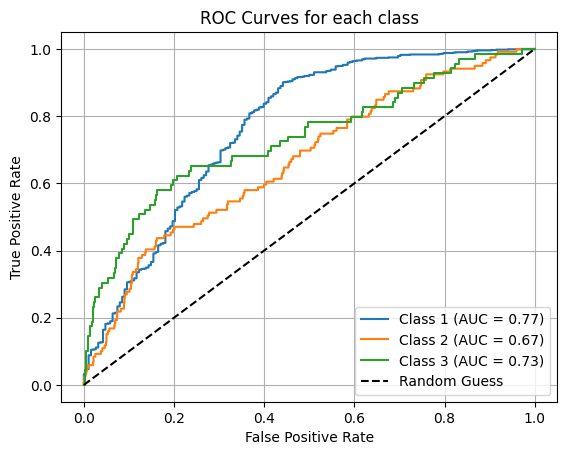


Mean F1 Score: 0.4691
Balanced Accuracy: 0.5070
Average AUPRC: 0.4567

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.81       907
           1       0.19      0.50      0.28       119
           2       0.34      0.29      0.31        69

    accuracy                           0.68      1095
   macro avg       0.48      0.51      0.47      1095
weighted avg       0.80      0.68      0.72      1095

Fold No: 3
Epoch [1/100], Loss: 1.0923, Accuracy: 0.4117
Validation Loss: 1.0254, Validation Accuracy: 0.4963
Epoch [2/100], Loss: 1.0613, Accuracy: 0.4759
Validation Loss: 0.9833, Validation Accuracy: 0.5126
Epoch [3/100], Loss: 1.0539, Accuracy: 0.4861
Validation Loss: 1.0933, Validation Accuracy: 0.4550
Epoch [4/100], Loss: 1.0462, Accuracy: 0.5059
Validation Loss: 0.9987, Validation Accuracy: 0.5279
Epoch [5/100], Loss: 1.0379, Accuracy: 0.5241
Validation Loss: 1.0262, Validation Accuracy: 0.4935
Epoch [6/100], Los

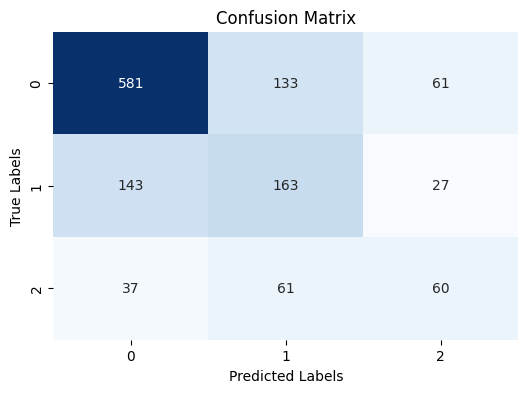


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 581/775 (74.97%)
Class 1: Correct Predictions / Total True Samples = 163/333 (48.95%)
Class 2: Correct Predictions / Total True Samples = 60/158 (37.97%)

Precision-Recall Curves:


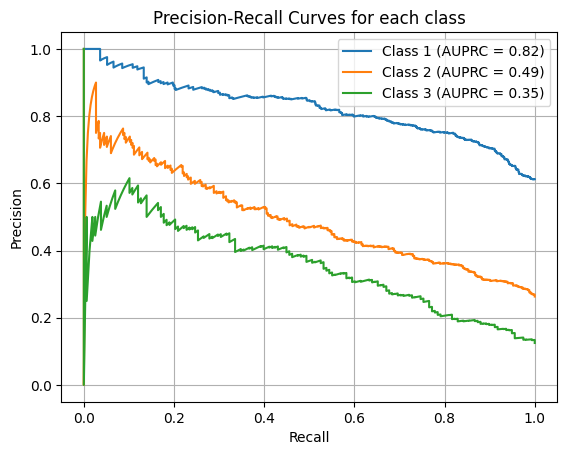


ROC Curves:


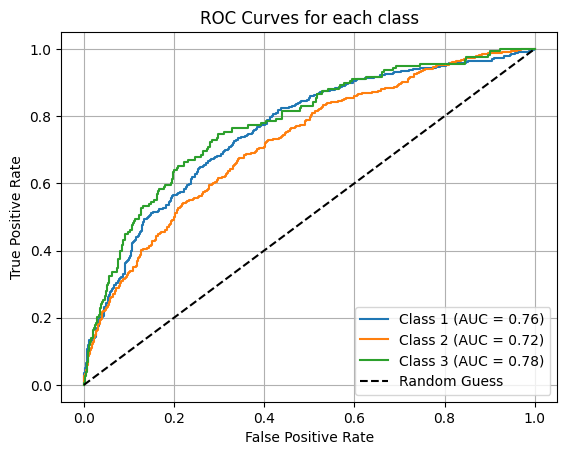


Mean F1 Score: 0.5404
Balanced Accuracy: 0.5396
Average AUPRC: 0.5560

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       775
           1       0.46      0.49      0.47       333
           2       0.41      0.38      0.39       158

    accuracy                           0.64      1266
   macro avg       0.54      0.54      0.54      1266
weighted avg       0.64      0.64      0.64      1266

Fold No: 4
Epoch [1/100], Loss: 1.0977, Accuracy: 0.3725
Validation Loss: 1.0962, Validation Accuracy: 0.3990
Epoch [2/100], Loss: 1.0838, Accuracy: 0.4275
Validation Loss: 1.1214, Validation Accuracy: 0.3993
Epoch [3/100], Loss: 1.0593, Accuracy: 0.4657
Validation Loss: 1.0318, Validation Accuracy: 0.4790
Epoch [4/100], Loss: 1.0611, Accuracy: 0.4657
Validation Loss: 1.0449, Validation Accuracy: 0.4991
Epoch [5/100], Loss: 1.0392, Accuracy: 0.5118
Validation Loss: 1.0053, Validation Accuracy: 0.4081
Epoch [6/100], Los

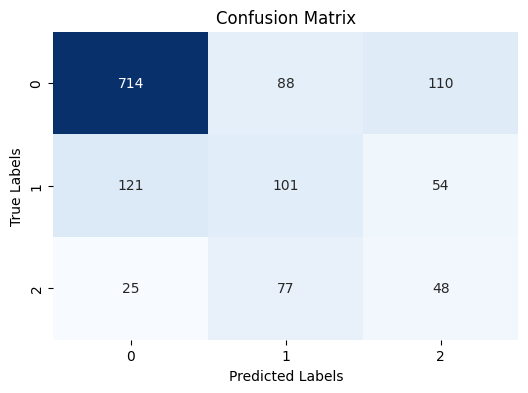


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 714/912 (78.29%)
Class 1: Correct Predictions / Total True Samples = 101/276 (36.59%)
Class 2: Correct Predictions / Total True Samples = 48/150 (32.00%)

Precision-Recall Curves:


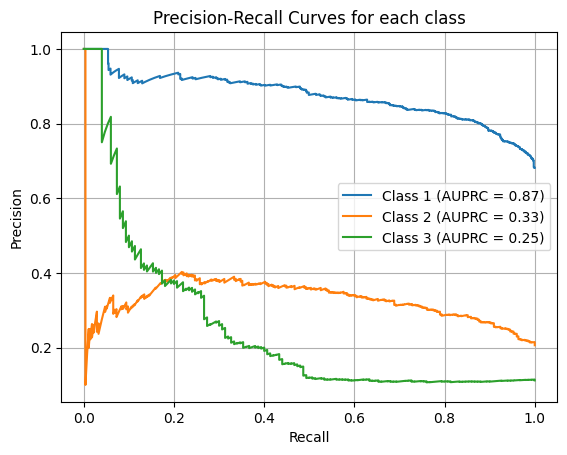


ROC Curves:


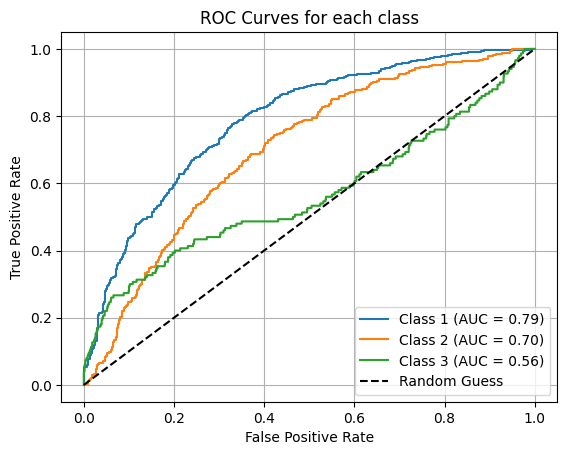


Mean F1 Score: 0.4813
Balanced Accuracy: 0.4896
Average AUPRC: 0.4832

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       912
           1       0.38      0.37      0.37       276
           2       0.23      0.32      0.27       150

    accuracy                           0.64      1338
   macro avg       0.48      0.49      0.48      1338
weighted avg       0.67      0.64      0.66      1338

Fold No: 5
Epoch [1/100], Loss: 1.0974, Accuracy: 0.3651
Validation Loss: 1.0914, Validation Accuracy: 0.5040
Epoch [2/100], Loss: 1.0748, Accuracy: 0.4480
Validation Loss: 1.0092, Validation Accuracy: 0.5542
Epoch [3/100], Loss: 1.0547, Accuracy: 0.4923
Validation Loss: 0.9712, Validation Accuracy: 0.5361
Epoch [4/100], Loss: 1.0477, Accuracy: 0.4933
Validation Loss: 0.9950, Validation Accuracy: 0.5426
Epoch [5/100], Loss: 1.0433, Accuracy: 0.5067
Validation Loss: 1.0229, Validation Accuracy: 0.5597
Epoch [6/100], Los

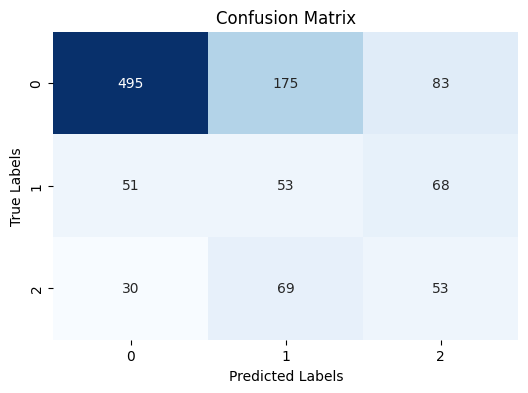


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 495/753 (65.74%)
Class 1: Correct Predictions / Total True Samples = 53/172 (30.81%)
Class 2: Correct Predictions / Total True Samples = 53/152 (34.87%)

Precision-Recall Curves:


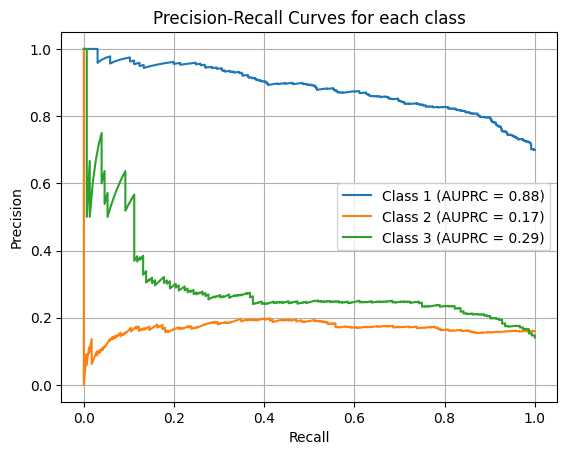


ROC Curves:


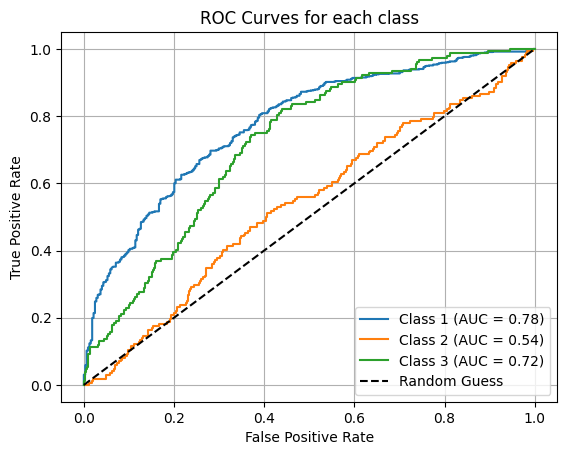


Mean F1 Score: 0.4229
Balanced Accuracy: 0.4381
Average AUPRC: 0.4468

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74       753
           1       0.18      0.31      0.23       172
           2       0.26      0.35      0.30       152

    accuracy                           0.56      1077
   macro avg       0.43      0.44      0.42      1077
weighted avg       0.67      0.56      0.60      1077


RESULTS FOR PARAMETER SET 4
Accuracy for each fold: ['0.5491', '0.5070', '0.5396', '0.4896', '0.4381']
Average Accuracy: 0.5047
AUPRC for each fold: ['0.5071', '0.4567', '0.5560', '0.4832', '0.4468']
Average AUPRC: 0.4900
Best fold class-wise balanced accuracy: ['0.6862', '0.3093', '0.2439']


RUNNING PARAMETER SET 5/5
Parameters: {'hidden_size': 1024, 'num_layers': 2, 'dropout': 0.4, 'learning_rate': 0.00014991153316823257, 'weight_decay': 2.666257997890808e-06, 'batch_size': 16, 'optimizer_name': 'Adam', 'label_smoo

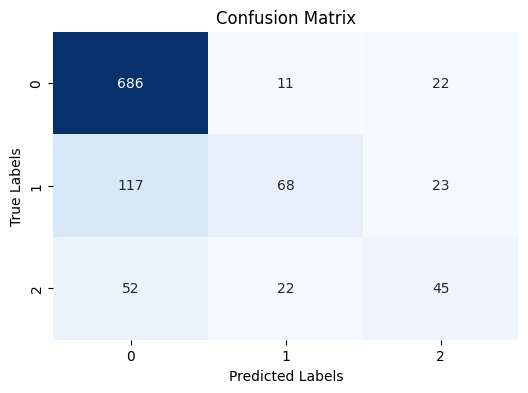


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 686/719 (95.41%)
Class 1: Correct Predictions / Total True Samples = 68/208 (32.69%)
Class 2: Correct Predictions / Total True Samples = 45/119 (37.82%)

Precision-Recall Curves:


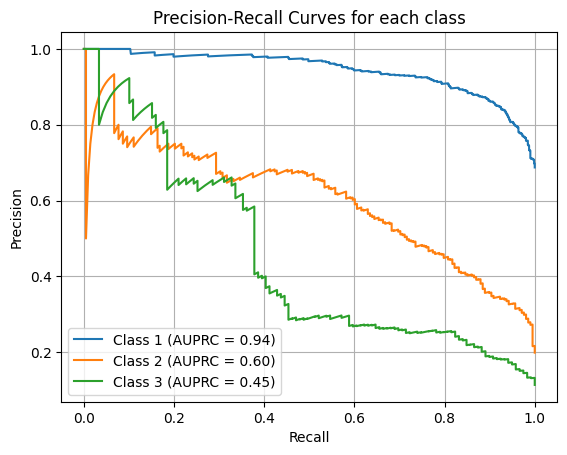


ROC Curves:


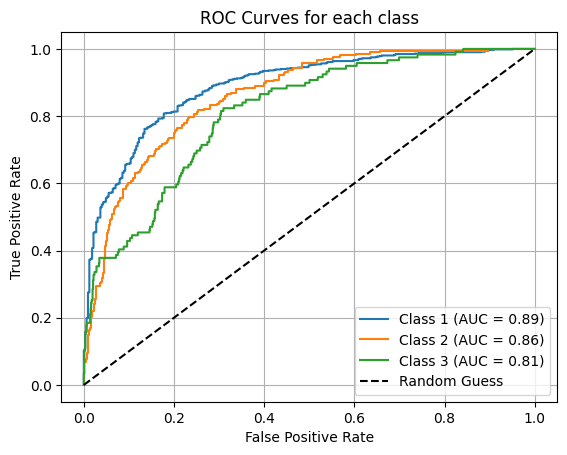


Mean F1 Score: 0.5808
Balanced Accuracy: 0.5531
Average AUPRC: 0.6646

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       719
           1       0.67      0.33      0.44       208
           2       0.50      0.38      0.43       119

    accuracy                           0.76      1046
   macro avg       0.66      0.55      0.58      1046
weighted avg       0.74      0.76      0.74      1046

Fold No: 2
Epoch [1/100], Loss: 1.0913, Accuracy: 0.3920
Validation Loss: 1.1326, Validation Accuracy: 0.3857
Epoch [2/100], Loss: 1.0652, Accuracy: 0.4565
Validation Loss: 1.1793, Validation Accuracy: 0.3817
Epoch [3/100], Loss: 1.0621, Accuracy: 0.4804
Validation Loss: 1.0784, Validation Accuracy: 0.4903
Epoch [4/100], Loss: 1.0518, Accuracy: 0.4862
Validation Loss: 0.9946, Validation Accuracy: 0.5068
Epoch [5/100], Loss: 1.0536, Accuracy: 0.4978
Validation Loss: 1.0512, Validation Accuracy: 0.4923
Epoch [6/100], Los

In [ ]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc

top_params = top_5_hyperparameters = [
    # Trial 45: Test Accuracy = 0.5825
    {
        'hidden_size': 128,
        'num_layers': 4,
        'dropout': 0.4,
        'learning_rate': 6.339492809821357e-05,
        'weight_decay': 5.137548693679295e-06,
        'batch_size': 16,
        'optimizer_name': 'Adam',
        'label_smoothing': 0.3,
        'factor': 1
    },
    
    # Trial 8: Test Accuracy = 0.5570
    {
        'hidden_size': 512,
        'num_layers': 1,
        'dropout': 0.30000000000000004,
        'learning_rate': 1.6047306777985417e-06,
        'weight_decay': 1.6488292763592139e-06,
        'batch_size': 10,
        'optimizer_name': 'Adam',
        'label_smoothing': 0.3,
        'factor': 1
    },
    
    # Trial 150: Test Accuracy = 0.5514
    {
        'hidden_size': 1024,
        'num_layers': 2,
        'dropout': 0.5,
        'learning_rate': 0.00032747731661669424,
        'weight_decay': 2.1882109116149925e-06,
        'batch_size': 10,
        'optimizer_name': 'Adam',
        'label_smoothing': 0.3,
        'factor': 1
    },
    
    # Trial 218: Test Accuracy = 0.5520 (but value was 0.5520485537821807 which is lower than trial 23)
    # Trial 23: Test Accuracy = 0.5459
    {
        'hidden_size': 256,
        'num_layers': 3,
        'dropout': 0.5,
        'learning_rate': 6.227130451805968e-05,
        'weight_decay': 2.7093785717647777e-06,
        'batch_size': 16,
        'optimizer_name': 'Adam',
        'label_smoothing': 0.3,
        'factor': 1
    },
    
    # Trial 144: Test Accuracy = 0.5454
    {
        'hidden_size': 1024,
        'num_layers': 2,
        'dropout': 0.4,
        'learning_rate': 0.00014991153316823257,
        'weight_decay': 2.666257997890808e-06,
        'batch_size': 16,
        'optimizer_name': 'Adam',
        'label_smoothing': 0.3,
        'factor': 1
    }
]

# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

# Model and training configurations
num_classes = 3
input_size = 224 * 3
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'



def calculate_class_wise_balanced_accuracy(y_true, y_pred, num_classes):
    """Calculate accuracy for each class using confusion matrix approach"""
    class_accuracies = []
    
    for i in range(num_classes):
        correct = np.sum((y_true == i) & (y_pred == i))
        total = np.sum((y_true == i) | (y_pred == i))
        class_accuracies.append(correct / total if total > 0 else 0.0)

    return class_accuracies

# Store results for all parameter sets
all_run_results = []

# Loop through all parameter sets
for param_idx, params in enumerate(top_params):
    print(f"\n{'='*80}")
    print(f"RUNNING PARAMETER SET {param_idx + 1}/5")
    print(f"{'='*80}")
    print(f"Parameters: {params}")
    print(f"{'='*80}\n")
    
    # Extract parameters
    hidden_size = params["hidden_size"]
    num_layers = params.get("num_layers", 1)
    dropout = params["dropout"]
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    
    # Initialize lists for this parameter set
    fold_accuracies = []
    fold_auprcs = []
    fold_confusion_matrices = []
    fold_class_wise_accuracies = []
    test_folds_chosen = []
    val_folds_chosen = []

    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')

        # Initialize model, loss, and optimizer
        fold_model = LstmAttention(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout
        ).to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], train_data.shape[2]*train_data.shape[3]))

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)

        early_stopping = EarlyStopping(patience=10)

        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold]
            val_data = val_data.reshape((val_data.shape[0], val_data.shape[1], val_data.shape[2]*val_data.shape[3]))
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels_batch in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels_batch)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels_batch.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold]
        test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], test_data.shape[2]*test_data.shape[3]))
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels_batch in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels_batch.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        # Calculate class-wise balanced accuracy
        class_wise_acc = calculate_class_wise_balanced_accuracy(np.array(test_labels_list), np.array(test_preds), num_classes)
        fold_class_wise_accuracies.append(class_wise_acc)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')
        print(f'Class-wise Balanced Accuracy: {[f"{acc:.4f}" for acc in class_wise_acc]}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Calculate best fold class-wise balanced accuracy
    fold_class_wise_accuracies = np.array(fold_class_wise_accuracies)
    best_fold_class_wise = np.max(fold_class_wise_accuracies, axis=0)

    # Final metrics across all folds for this parameter set
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    
    print(f"\n{'='*60}")
    print(f"RESULTS FOR PARAMETER SET {param_idx + 1}")
    print(f"{'='*60}")
    print(f'Accuracy for each fold: {[f"{acc:.4f}" for acc in fold_accuracies]}')
    print(f'Average Accuracy: {mean_accuracy:.4f}')
    print(f'AUPRC for each fold: {[f"{auprc:.4f}" for auprc in fold_auprcs]}')
    print(f'Average AUPRC: {average_auprc:.4f}')
    print(f'Best fold class-wise balanced accuracy: {[f"{acc:.4f}" for acc in best_fold_class_wise]}')
    print(f"{'='*60}\n")
    
    # Store results for final summary
    run_result = {
        'param_set': param_idx + 1,
        'params': params,
        'fold_accuracies': fold_accuracies,
        'average_accuracy': mean_accuracy,
        'fold_auprcs': fold_auprcs,
        'average_auprc': average_auprc,
        'best_fold_class_wise_accuracy': best_fold_class_wise
    }
    all_run_results.append(run_result)
    

# Final summary of all runs
print(f"\n{'='*80}")
print(f"FINAL SUMMARY OF ALL 5 PARAMETER SETS")
print(f"{'='*80}")

for result in all_run_results:
    print(f"\nParameter Set {result['param_set']}:")
    print(f"Parameters: {result['params']}")
    print(f"Accuracy for each fold: {[f'{acc:.4f}' for acc in result['fold_accuracies']]}")
    print(f"Average Accuracy: {result['average_accuracy']:.4f}")
    print(f"AUPRC for each fold: {[f'{auprc:.4f}' for auprc in result['fold_auprcs']]}")
    print(f"Average AUPRC: {result['average_auprc']:.4f}")
    print(f"Best fold class-wise balanced accuracy: {[f'{acc:.4f}' for acc in result['best_fold_class_wise_accuracy']]}")
    print("-" * 60)

print(f"{'='*80}")
